In [1]:
#%load_ext snakeviz
%matplotlib inline

In [2]:
#librerias utilitarias
from random import randint
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
from utils.multi_gpu import make_parallel

In [5]:
!nvidia-smi

Fri Jun 16 01:56:50 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:17.0     Off |                    0 |
| N/A   62C    P0    62W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:00:18.0     Off |                    0 |
| N/A   50C    P0    74W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Cargar Datos
___

In [4]:
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
#print (np.unique(y_train))
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 10)
(26032, 10)


### Preparar paralelismo
___

Para parelizar la ejecución del modelo a nivel de datos se debe tener complir la siguiente relación:

$$ \frac{\frac{datos-de-entrenamiento}{batches}}{Nº GPU`s} = 0$$

Por quitamos 1 ejemplo de entreamiento y otro de test. 

In [5]:
Y_test_parallel =np.delete(Y_test, 1, 0)
X_test_parallel =np.delete(X_test, 1, 0)
Y_train_parallel =np.delete(Y_train, 1, 0)
X_train_parallel =np.delete(X_train, 1, 0)
print (X_train_parallel.shape)
print (X_test_parallel.shape)
print (Y_train_parallel.shape)
print (Y_test_parallel.shape)

(73256, 3, 32, 32)
(26031, 3, 32, 32)
(73256, 10)
(26031, 10)


Objetivo
-----

**(F)** Proponga una mejora sobre la red definida en (c) que mejore el error de pruebas.

In [7]:
#Parametros
_size, n_channels, n_rows, n_cols = X_train_parallel.shape

In [8]:
model_c = Sequential()
model_c.add(Convolution2D(16, (5, 5), padding='same', activation='relu',
                        input_shape=(n_channels, n_rows, n_cols)))
model_c.add(MaxPooling2D(pool_size=(2, 2)))
model_c.add(Convolution2D(512, (7, 7), padding='same', activation='relu'))
model_c.add(MaxPooling2D(pool_size=(2, 2)))
model_c.add(Flatten())
model_c.add(Dense(20, activation='relu'))
model_c.add(Dense(n_classes, activation='softmax'))
#model_c.summary()

**Modelo propuesto**
Como mejora, y antes los resultados exitosos conocidos como en un aumento creciente del numero de filtros en las capas convolucionales pero de forma gradual (no pasar de 16 a 512) como en el caso de la red AlexNet o los trabajos propuestos por goodfellow (textoguia), es que la modificación propuesta implica agregar una capa mas y distribuir el aumento de los filtros 48-64-128, además agregar Dropout(0.25) entre cada capa para buscar mayor generalización del modelo (evitar overfitting).


In [10]:
model_p = Sequential()
model_p.add(Convolution2D(48, (5, 5), padding='same', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model_p.add(MaxPooling2D(pool_size=(2, 2)))
model_p.add(Dropout(0.25))

model_p.add(Convolution2D(64, (5, 5),padding='same', activation='relu'))
model_p.add(MaxPooling2D(pool_size=(2, 2)))
model_p.add(Dropout(0.25))

model_p.add(Convolution2D(128, (5, 5), padding='same', activation='relu'))
model_p.add(MaxPooling2D(pool_size=(2, 2)))
model_p.add(Dropout(0.25))

model_p.add(Flatten())
model_p.add(Dense(20, activation='relu'))
model_p.add(Dense(n_classes, activation='softmax'))
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 16, 16)       401920    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 512, 8, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total para

In [11]:
opt = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

In [65]:
model_p = make_parallel(model_p, 8)

/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


In [76]:
model_c = make_parallel(model_c, 8)

/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


In [66]:
epochs = 10
#batch_size= 32
batch_size=1280

In [67]:
%%time
model_p.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 21.8 ms


In [80]:
%%time
model_c.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 21.6 ms


In [68]:
%%time
history_p = model_p.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 5min 31s, sys: 1min 53s, total: 7min 24s
Wall time: 1min 31s


In [81]:
%%time
history_c = model_c.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 46s, sys: 2min 15s, total: 9min 2s
Wall time: 1min 54s


### Comentarios
---

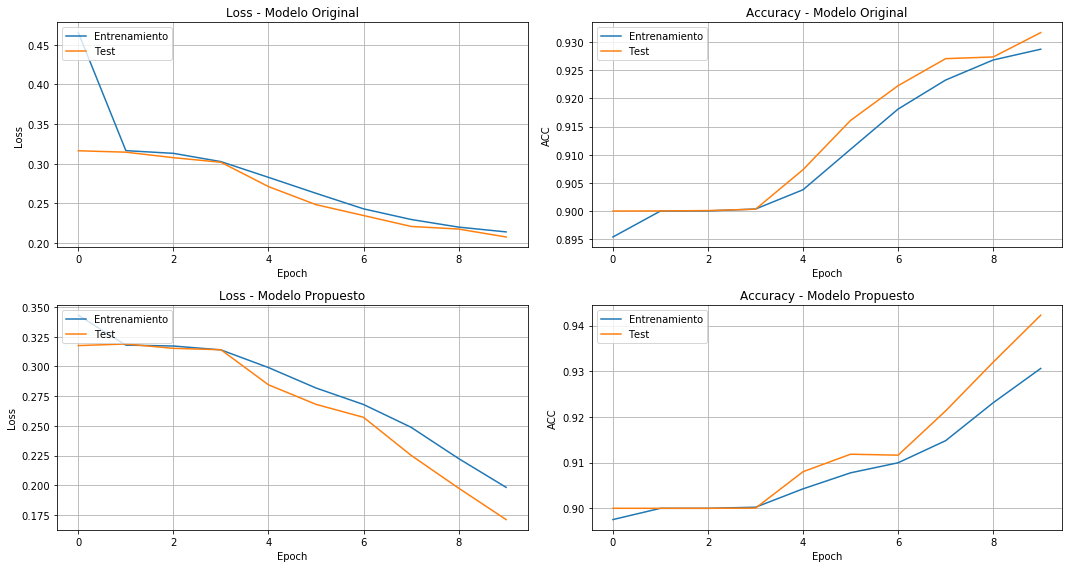

In [84]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history_c.history['loss'])  
plt.plot(history_c.history['val_loss'])  
plt.title('Loss - Modelo Original')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_c.history['acc'])  
plt.plot(history_c.history['val_acc'])  
plt.title('Accuracy - Modelo Original')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_p.history['loss'])  
plt.plot(history_p.history['val_loss'])  
plt.title('Loss - Modelo Propuesto')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history_p.history['acc'])  
plt.plot(history_p.history['val_acc'])  
plt.title('Accuracy - Modelo Propuesto')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Comentarios
---

Con el modelo propuesto mejoramos el accuracy del modelo, pasando de un 93.17%
a un 94.23%. Además la curva accuracy tiene un comportamiento mas estable. 


In [79]:
#%%time
scores = model_p.evaluate(X_test, Y_val)
print("")
print("Accuracy del modelo Propuesto: %.2f%%" % (scores[1]*100))
print("Loss del modelo con Propuesto: %.2f%%" % (scores[0]*100))

25888/26032 [============================>.] - ETA: 0s 

In [83]:
#%%time
scores = model_c.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con Original : %.2f%%" % (scores[1]*100))
print("Loss del modelo Origina: %.2f%%" % (scores[0]*100))

25984/26032 [============================>.] - ETA: 0s 